# 📊 Customer Churn Analysis with BigQuery & Python 🚀 Modelling stage

In this notebook we will build logistic regression models using the variables we created in the exploratory data analyisis notebook. 

Fisrt, let's bring the table from bigquery, a tool that has served us well in this journey:


In [12]:
import os
from google.cloud import bigquery
import pandas as pd

# let's set up the BigQuery client
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/workspaces/ABCBankChurnRate/.config/sa_credentials.json"
client = bigquery.Client()

# Load the modified dataset
query = """
SELECT *
FROM `kagglebigquerybankchurn.churn_analysis.cleaned_churn`
"""

model_df = client.query(query).to_dataframe()

# Check the first few rows of the DataFrame
print(model_df.head())

   customer_id  credit_score gender  age  tenure  balance  products_number  \
0     15570086           684   Male   18       9  90544.0                1   
1     15570086           684   Male   18       9  90544.0                1   
2     15570086           684   Male   18       9  90544.0                1   
3     15570086           684   Male   18       9  90544.0                1   
4     15570086           684   Male   18       9  90544.0                1   

   credit_card  active_member  estimated_salary  churn   log_age  \
0            0              1           4777.23      0  2.890372   
1            0              1           4777.23      0  2.890372   
2            0              1           4777.23      0  2.890372   
3            0              1           4777.23      0  2.890372   
4            0              1           4777.23      0  2.890372   

  binned_salary  zero_balance_flag  high_products  country_France  \
0            Q1                  0              0    

Just as a reminder, in the previous notebook we :
- identified that country may be one hot encoded, so three new variables were created, one for each country.
- noticed that the balance variable was zero inflated, so a `zero_balance_flag` variable was included.
- noticed that the estimated salary had an uniform distribution which we tried to assess by creating bins, but the bins are also uniform, so we might not use this at all..
- found that the age variable was right skewed which is expected for these datasets, so a log_age variable was created
- there was a grouping for 1 and 2, and 3 and 4 number of products, so a new variable high_products was created to address this grouping

Let's plot the last visualization, which includes the original variables, and the variables we just discussed:

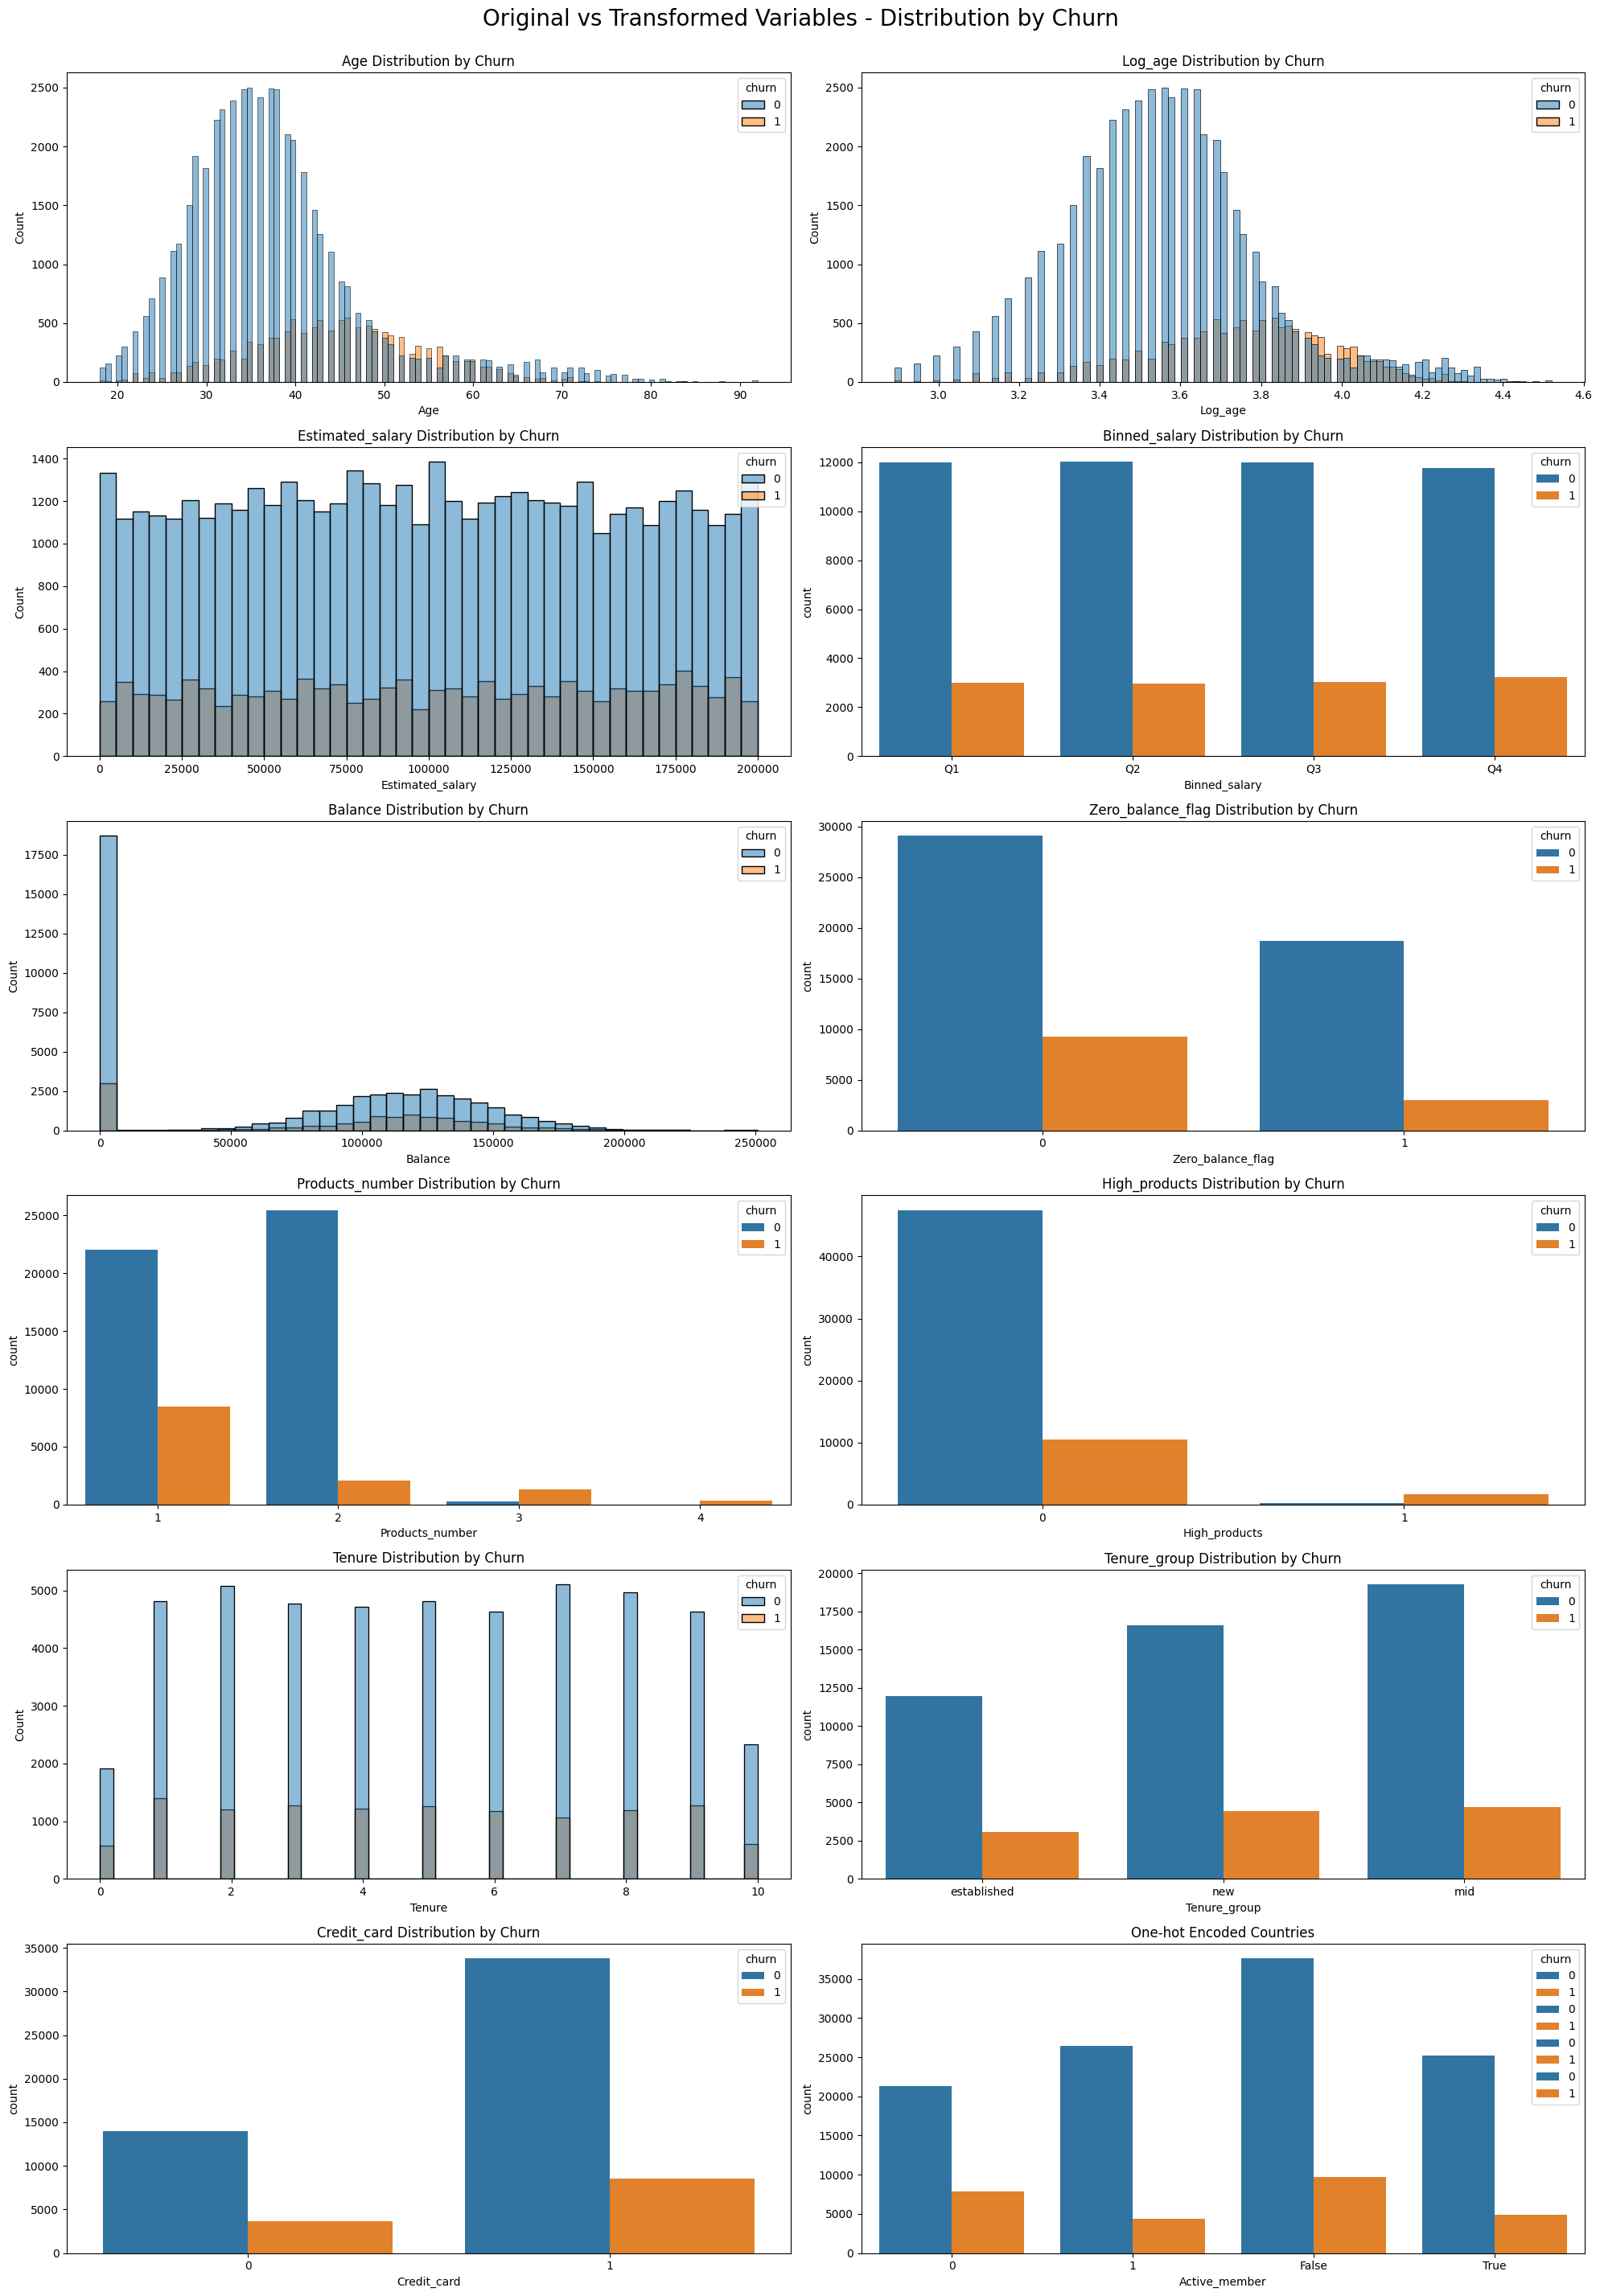

In [13]:
# Import required libraries if not already imported
import matplotlib.pyplot as plt
import seaborn as sns

# Set up figure for comparing original and all transformed variables
fig, axes = plt.subplots(6, 2, figsize=(20, 30))
fig.suptitle('Original vs Transformed Variables - Distribution by Churn', fontsize=20, y=0.95)

# Define pairs of original and transformed variables
# Removing country comparison since it's already one-hot encoded
comparisons = [
    ('age', 'log_age'),
    ('estimated_salary', 'binned_salary'),
    ('balance', 'zero_balance_flag'),
    ('products_number', 'high_products'),
    ('tenure', 'tenure_group'),
    ('credit_card', 'active_member')  # Original categorical variables
]

# Plot each comparison
for i, (orig, trans) in enumerate(comparisons):
    # Original variable
    if orig in ['products_number', 'credit_card', 'active_member']:  # Categorical originals
        sns.countplot(data=model_df, x=orig, hue='churn', ax=axes[i, 0])
    else:  # Continuous originals
        sns.histplot(data=model_df, x=orig, hue='churn', multiple="layer", alpha=0.5, ax=axes[i, 0])
    axes[i, 0].set_title(f'{orig.capitalize()} Distribution by Churn')
    axes[i, 0].set_xlabel(orig.capitalize())
    
    # Transformed variable
    if trans in ['binned_salary', 'zero_balance_flag', 'high_products', 'tenure_group', 'active_member']:  
        # Categorical transformed
        sns.countplot(data=model_df, x=trans, hue='churn', ax=axes[i, 1])
    else:  # Continuous transformed
        sns.histplot(data=model_df, x=trans, hue='churn', multiple="layer", alpha=0.5, ax=axes[i, 1])
    axes[i, 1].set_title(f'{trans.capitalize()} Distribution by Churn')
    axes[i, 1].set_xlabel(trans.capitalize())

# Add special plot for country columns
country_cols = ['country_France', 'country_Germany', 'country_Spain']
for col in country_cols:
    sns.countplot(data=model_df, x=col, hue='churn', ax=axes[5, 1])
axes[5, 1].set_title('One-hot Encoded Countries')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In the previous notebook we forgot to one-hot encode the tenure_group variable using dummy variables. let's do that now:

In [14]:
# Convert tenure_group to dummy variables if not already done
model_df = pd.get_dummies(model_df, columns=['tenure_group'], prefix='tenure_group')
model_df.head()

,customer_id,credit_score,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,log_age,binned_salary,zero_balance_flag,high_products,country_France,country_Germany,country_Spain,tenure_group_established,tenure_group_mid,tenure_group_new
0,15570086,684,Male,18,9,90544.0,1,0,1,4777.23,...,2.890372,Q1,0,0,False,True,False,True,False,False
1,15570086,684,Male,18,9,90544.0,1,0,1,4777.23,...,2.890372,Q1,0,0,False,True,False,True,False,False
2,15570086,684,Male,18,9,90544.0,1,0,1,4777.23,...,2.890372,Q1,0,0,False,True,False,True,False,False
3,15570086,684,Male,18,9,90544.0,1,0,1,4777.23,...,2.890372,Q1,0,0,False,True,False,True,False,False
4,15570086,684,Male,18,9,90544.0,1,0,1,4777.23,...,2.890372,Q1,0,0,False,True,False,True,False,False


Now we have three dummy variables for the tenure_group variable. great!

# modelling

Now, we will try to train the model. As industry standard we should select a leave out sample to test the model after it's creation from the train subset. 

Then, we will need python functions to do thes, thankfully scikit learn has functions to do this. let's import them:


In [ ]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Now, we should select which feature sthe model will use to be trained, let's do a data informed decision based on what we learned in the EDA:

In [6]:
features = [
    'credit_score', 'log_age', 'zero_balance_flag', 'high_products',
    'active_member', 'country_France', 'country_Germany', 'country_Spain',
    'tenure_group_new', 'tenure_group_mid', 'tenure_group_established'
]

Next, we will prepare the features in the varaible X, and churn (the target) as Y, for syntax efficiency purposes.

In [15]:
X=model_df[features]
Y=model_df['churn']

Now, let's split the data into train and test, using the scikit learn function:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

Given the nature of the data (class inbalance) stratified sample is used. let's visualize this really quick

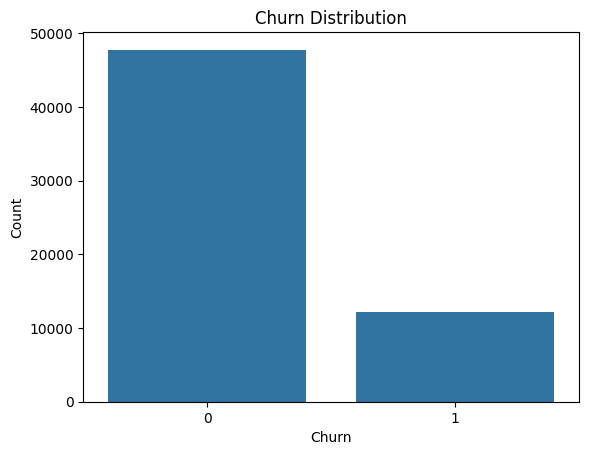

In [17]:
# A count plot of the churn variable:
sns.countplot(data=model_df, x='churn')
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


By using stratified sampling  we split the dataset so that the proportion of each class (no churn and churn) in the target variable stays the same both in the training and test sets. ^_^\

Now that we have our training and test sets, we can train the model as follows:

In [21]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Once we have trained the model, we can do predictions on the test set to evaluate it:

In [22]:
# Make predictions
y_pred= model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] 

next, we can calulate metrics as:
- **precision**, which indicates the proportion of cases that were labeled as churn, are true positives.
- **recall**, which shows the proportion, of true positives out of the total true cases 
- **Accuracy**, which shows the overall prediction power, adding true positives and true negatives, and dividing by the total number of cases

In [23]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

Accuracy: 0.838
Precision: 0.765
Recall: 0.298


We got a high accuracy and precision, and low recall. this is normal because there is a class inbalance where there is too many values for zero. since models aim to minimize overal error, and not maximize class specific performance, the model will learn to focus on predicting class 0 correctly.


now let's visualize a confusion matrix, which shows us the true positives and true negatives:

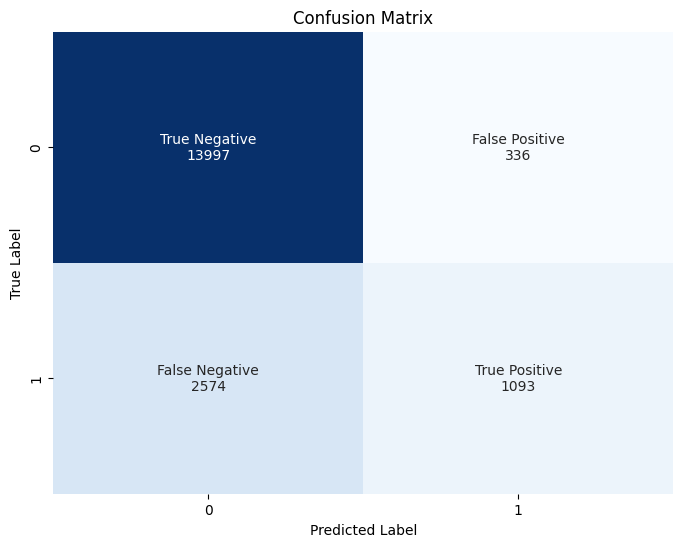

In [30]:

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# Define labels for each square
labels = np.array([["True Negative", "False Positive"], 
                   ["False Negative", "True Positive"]])

# Create a heatmap with annotations
sns.heatmap(cm, annot=labels + "\n" + cm.astype(str), fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


These classifications are made using a fixed threshold, like 0.5:
![Threshold Illustration](/workspaces/ABCBankChurnRate/img/threshold.png)

To see how the model classifies at different thresholds we can use the receiving operator curve (ROC) as follows:

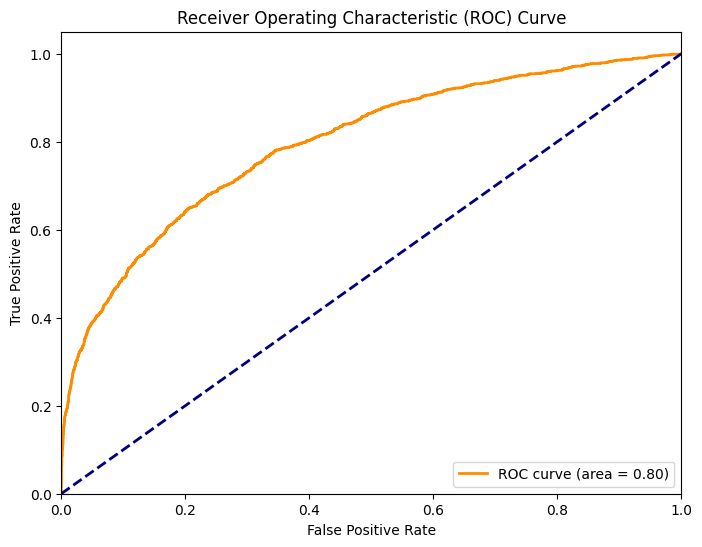

In [28]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Now let's use the model's coefficients to visualize which features are important to predict churn:

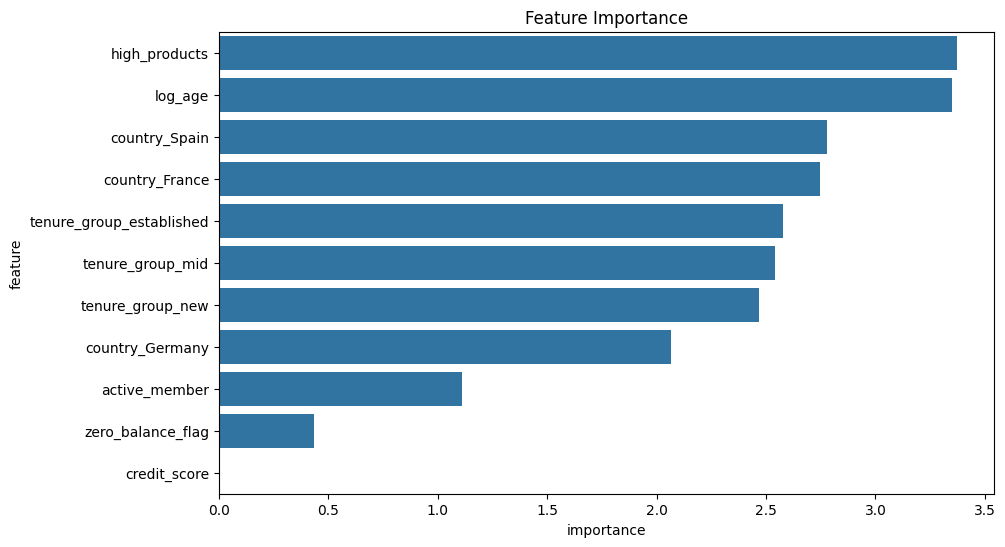

In [29]:
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()